Total Mass of the Planet: 5.98796e+24 kg
Sum of all scaled particle masses: 5.98796e+24 kg
Time taken: 0.032651424407958984 seconds


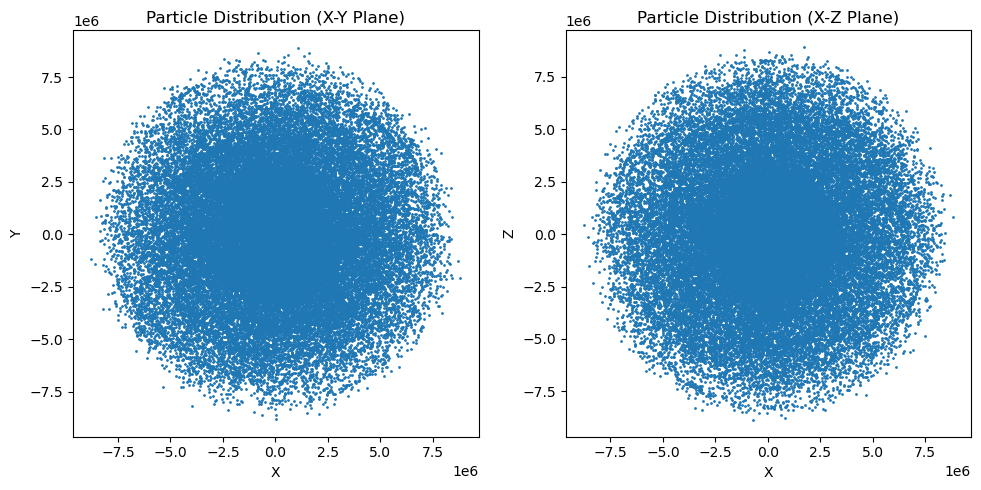

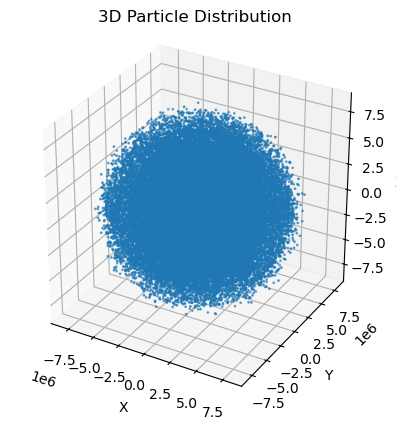

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm
import sys
import time

def read_hercules_output(file_path):
    # Read the binary file containing the planet's parameters and density profile
    with open(file_path, 'rb') as f:
        parameters = HERCULES_parameters()
        parameters.read_binary(f)
        planet = HERCULES_planet()
        planet.read_binary(f)
    return planet

def shell_volume(r1, r2):
    return (4/3) * np.pi * (r1**3 - r2**3)

def calculate_particles_in_shell(shell_mass, num_particles, total_mass):
    num_particles_per_shell = (shell_mass * num_particles) / total_mass
    return int(np.round(num_particles_per_shell))

def generate_particle_coordinates(r1, r2, num_particles):
    phi = np.random.uniform(0, 2 * np.pi, num_particles)
    theta = np.random.uniform(0, np.pi, num_particles)
    
    u = np.random.uniform(0, 1, num_particles)
    r = r2 + (r1 - r2) * u**(1/3)

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return x, y, z

def equal_area_latitude_stretching(x, y, z, N):
    num_collars = int(np.sqrt(N))
    num_regions_per_collar = int(N / num_collars)
    
    a = 0.2
    b = 2
    
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    
    theta_stretched = np.arccos(np.cos(theta) * np.sqrt(1 - a * np.sin(theta) ** 2))
    
    x_stretched = r * np.sin(theta_stretched) * np.cos(np.arctan2(y, x))
    y_stretched = r * np.sin(theta_stretched) * np.sin(np.arctan2(y, x))
    z_stretched = r * np.cos(theta_stretched)
    
    return x_stretched, y_stretched, z_stretched

def rotate_particles(x, y, z):
    theta = np.random.uniform(0, 2 * np.pi)
    phi = np.random.uniform(0, np.pi)
    
    R = np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi)],
        [np.sin(theta), np.cos(theta)*np.cos(phi), -np.cos(theta)*np.sin(phi)],
        [0, np.sin(phi), np.cos(phi)]
    ])
    
    rotated_coords = np.dot(R, np.vstack([x, y, z]))
    return rotated_coords[0], rotated_coords[1], rotated_coords[2]

def main():
    start_time = time.time()  # Start timing
    file_path = "C:\\Users\\Nischayee\\HERCULES\\Tutorial\\Analysis Script\\output\\Non-rotating_L0_N50_Nm200_k12_f021_p10_l0.92_0.1_2_17"
    planet = read_hercules_output(file_path)
    
    total_mass = planet.Mtot
    print(f"Total Mass of the Planet: {total_mass:.5e} kg")
    
    num_particles = 50000
    
    layers = planet.Nlayer
    particle_positions = []
    particle_masses = []
    particle_densities = []

    all_particles_count = 0
    
    for i in range(layers):
        shell_density = planet.real_rho[i]
        current_radius = planet.layers[i].a
        next_radius = planet.layers[i + 1].a if i < layers - 1 else 0
        
        shell_vol = shell_volume(current_radius, next_radius)
        
        if shell_vol < 0:
            raise ValueError(f"Negative volume calculated at layer {i}. Check radius values.")
        
        shell_mass = shell_density * shell_vol
        num_shell_particles = calculate_particles_in_shell(shell_mass, num_particles, total_mass)
        all_particles_count += num_shell_particles
        
        if num_shell_particles > 0:
            x, y, z = generate_particle_coordinates(current_radius, next_radius, num_shell_particles)
            x, y, z = equal_area_latitude_stretching(x, y, z, num_shell_particles)
            x, y, z = rotate_particles(x, y, z)
            
            # Store positions
            particle_positions.append((x, y, z))
            
            # Store the density
            particle_densities.append(np.full(num_shell_particles, shell_density))
        

    # Scale the mass of each particle
    mass_per_particle = total_mass / all_particles_count

    # Apply the scaled mass to all particles
    for i in range(len(particle_positions)):
        particle_masses.append(np.full(len(particle_positions[i][0]), mass_per_particle))
    
    # Concatenate all properties
    x_all = np.concatenate([p[0] for p in particle_positions])
    y_all = np.concatenate([p[1] for p in particle_positions])
    z_all = np.concatenate([p[2] for p in particle_positions])

    all_masses = np.concatenate(particle_masses)
    all_densities = np.concatenate(particle_densities)

    # Print the sum of all scaled particle masses
    print(f"Sum of all scaled particle masses: {np.sum(all_masses):.5e} kg")

    end_time = time.time()  # End timing
    print(f"Time taken: {end_time - start_time} seconds")

    plt.figure(figsize=(10, 5))
    
    # Determine the limits based on the particle coordinates
    x_lim = max(np.abs(x_all.min()), np.abs(x_all.max()))
    y_lim = max(np.abs(y_all.min()), np.abs(y_all.max()))
    z_lim = max(np.abs(z_all.min()), np.abs(z_all.max()))
    lim = max(x_lim, y_lim, z_lim)
    
    # XY Plane plot
    plt.subplot(1, 2, 1)
    plt.scatter(x_all, y_all, s=1)
    plt.title('Particle Distribution (X-Y Plane)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.axis('equal')
    
    # XZ Plane plot
    plt.subplot(1, 2, 2)
    plt.scatter(x_all, z_all, s=1)
    plt.title('Particle Distribution (X-Z Plane)')
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 3D distribution with aspect ratio closer to 1:1:1
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_all, y_all, z_all, s=1)
    ax.set_title('3D Particle Distribution')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])  # Aspect ratio is 1:1:1
    
    # Set limits to ensure aspect ratio is reflected properly
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.set_zlim([-lim, lim])
    
    plt.show()

   
if __name__ == "__main__":
    main()


## Calculated mass of all layers v/s Scaled mass NON- rotating

Total Mass of the Planet: 5.98796e+24 kg


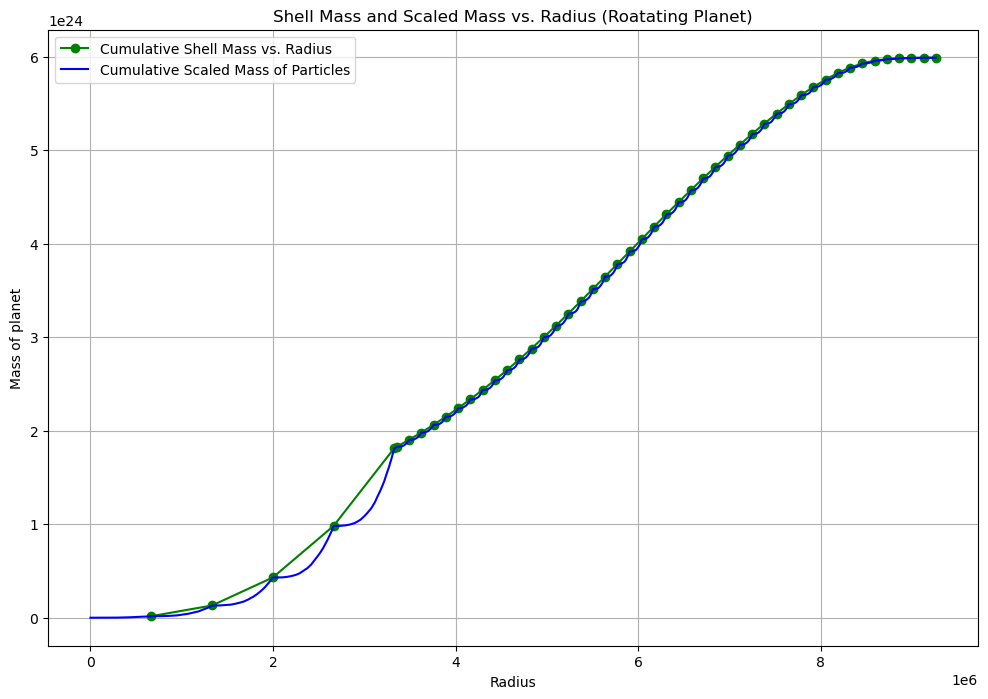

Sum of all scaled particle masses: 5.98796e+24 kg
Time taken: 0.5074176788330078 seconds


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm
import sys
import time

sys.path.append('/home/kh23622/HERCULES_development/Python_scripts')
from HERCULES_structures import *


def read_hercules_output(file_path):
    # Read the binary file containing the planet's parameters and density profile
    with open(file_path, 'rb') as f:
        parameters = HERCULES_parameters()
        parameters.read_binary(f)
        planet = HERCULES_planet()
        planet.read_binary(f)
    return planet

def shell_volume(r1, r2):
    return (4/3) * np.pi * (r1**3 - r2**3)

def calculate_particles_in_shell(shell_mass, num_particles, total_mass):
    num_particles_per_shell = (shell_mass * num_particles) / total_mass
    return int(np.round(num_particles_per_shell))

def generate_particle_coordinates(r1, r2, num_particles):
    phi = np.random.uniform(0, 2 * np.pi, num_particles)
    theta = np.random.uniform(0, np.pi, num_particles)
    
    u = np.random.uniform(0, 1, num_particles)
    r = r2 + (r1 - r2) * u**(1/3)

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return x, y, z

def equal_area_latitude_stretching(x, y, z, N):
    a = 0.2
    
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    
    theta_stretched = np.arccos(np.cos(theta) * np.sqrt(1 - a * np.sin(theta) ** 2))
    
    x_stretched = r * np.sin(theta_stretched) * np.cos(np.arctan2(y, x))
    y_stretched = r * np.sin(theta_stretched) * np.sin(np.arctan2(y, x))
    z_stretched = r * np.cos(theta_stretched)
    
    return x_stretched, y_stretched, z_stretched

def rotate_particles(x, y, z):
    theta = np.random.uniform(0, 2 * np.pi)
    phi = np.random.uniform(0, np.pi)
    
    R = np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi)],
        [np.sin(theta), np.cos(theta)*np.cos(phi), -np.cos(theta)*np.sin(phi)],
        [0, np.sin(phi), np.cos(phi)]
    ])
    
    rotated_coords = np.dot(R, np.vstack([x, y, z]))
    return rotated_coords[0], rotated_coords[1], rotated_coords[2]

def main():
    start_time = time.time()  # Start timing
    file_path = "C:\\Users\\Nischayee\\HERCULES\\Tutorial\\Analysis Script\\output\\Non-rotating_L0_N50_Nm200_k12_f021_p10_l0.92_0.1_2_17"
    planet = read_hercules_output(file_path)
    
    total_mass = planet.Mtot
    print(f"Total Mass of the Planet: {total_mass:.5e} kg")
    
    num_particles = 50000
    
    layers = planet.Nlayer
    particle_positions = []
    particle_masses = []
    particle_densities = []

    all_particles_count = 0
    shell_radii = []
    shell_masses = []
    
    for i in range(layers):
        shell_density = planet.real_rho[i]
        current_radius = planet.layers[i].a
        next_radius = planet.layers[i + 1].a if i < layers - 1 else 0
        
        shell_vol = shell_volume(current_radius, next_radius)
        
        if shell_vol < 0:
            raise ValueError(f"Negative volume calculated at layer {i}. Check radius values.")
        
        shell_mass = shell_density * shell_vol
        shell_radii.append(current_radius)
        shell_masses.append(shell_mass)
        
        num_shell_particles = calculate_particles_in_shell(shell_mass, num_particles, total_mass)
        all_particles_count += num_shell_particles
        
        if num_shell_particles > 0:
            x, y, z = generate_particle_coordinates(current_radius, next_radius, num_shell_particles)
            x, y, z = equal_area_latitude_stretching(x, y, z, num_shell_particles)
            x, y, z = rotate_particles(x, y, z)
            
            # Store positions
            particle_positions.append((x, y, z))
            
            # Store the density
            particle_densities.append(np.full(num_shell_particles, shell_density))
    
    # Scale the mass of each particle
    mass_per_particle = total_mass / all_particles_count

    # Apply the scaled mass to all particles
    for i in range(len(particle_positions)):
        particle_masses.append(np.full(len(particle_positions[i][0]), mass_per_particle))
    
    # Concatenate all properties
    x_all = np.concatenate([p[0] for p in particle_positions])
    y_all = np.concatenate([p[1] for p in particle_positions])
    z_all = np.concatenate([p[2] for p in particle_positions])

    all_masses = np.concatenate(particle_masses)
    all_densities = np.concatenate(particle_densities)

    # Calculate the cumulative mass vs radius
    cumulative_mass = np.zeros_like(shell_radii)
    sorted_radii = np.sort(shell_radii)
    cumulative_mass_sorted = np.zeros_like(sorted_radii)

    for i, r in enumerate(sorted_radii):
        cumulative_mass_sorted[i] = np.sum([shell_mass for radius, shell_mass in zip(shell_radii, shell_masses) if radius <= r])
    
    # Calculate the cumulative scaled mass vs radius
    radius_range = np.linspace(0, np.max(shell_radii), 1000)
    cumulative_scaled_mass = np.zeros_like(radius_range)
    
    for i, r in enumerate(radius_range):
        num_particles_greater_than_r = np.sum(np.sqrt(x_all**2 + y_all**2 + z_all**2) <= r)
        cumulative_scaled_mass[i] = (num_particles_greater_than_r / len(x_all)) * total_mass

    # Plot Mass vs Radius
    plt.figure(figsize=(12, 8))
    
    # Plot the cumulative mass of the planet's layers vs radius
    plt.plot(sorted_radii, cumulative_mass_sorted, 'o-', color='green', label='Cumulative Shell Mass vs. Radius')
    
    # Plot the cumulative scaled mass of particles vs radius
    plt.plot(radius_range, cumulative_scaled_mass, color='blue', label='Cumulative Scaled Mass of Particles')
    
    plt.xlabel('Radius')
    plt.ylabel('Mass of planet')
    plt.title('Shell Mass and Scaled Mass vs. Radius (Roatating Planet)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the sum of all scaled particle masses
    print(f"Sum of all scaled particle masses: {np.sum(all_masses):.5e} kg")
    
    end_time = time.time()  # End timing
    print(f"Time taken: {end_time - start_time} seconds")

   
if __name__ == "__main__":
    main()


## Particle distribution in rotating planet

Total Mass of the Planet: 5.98796e+24 kg
Sum of all scaled particle masses: 5.98796e+24 kg
Time taken: 0.05780506134033203 seconds


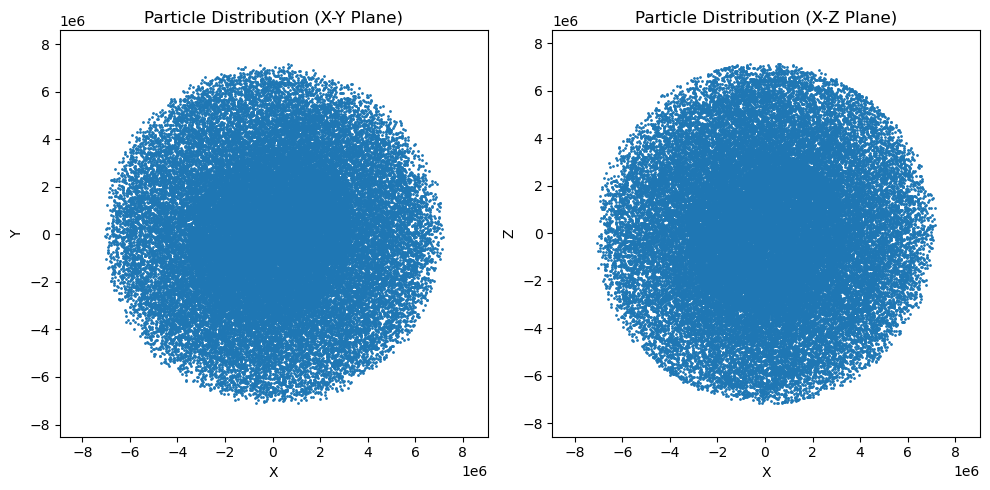

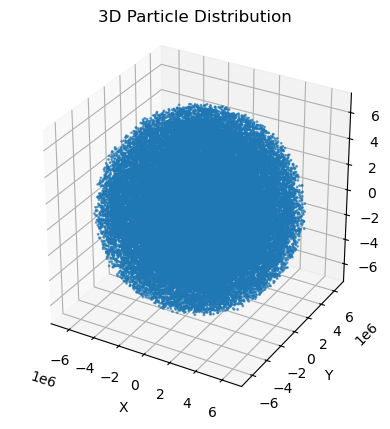

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm
import sys
import time

def read_hercules_output(file_path):
    # Read the binary file containing the planet's parameters and density profile
    with open(file_path, 'rb') as f:
        parameters = HERCULES_parameters()
        parameters.read_binary(f)
        planet = HERCULES_planet()
        planet.read_binary(f)
    return planet

def shell_volume(r1, r2):
    return (4/3) * np.pi * (r1**3 - r2**3)

def calculate_particles_in_shell(shell_mass, num_particles, total_mass):
    num_particles_per_shell = (shell_mass * num_particles) / total_mass
    return int(np.round(num_particles_per_shell))

def generate_particle_coordinates(r1, r2, num_particles):
    phi = np.random.uniform(0, 2 * np.pi, num_particles)
    theta = np.random.uniform(0, np.pi, num_particles)
    
    u = np.random.uniform(0, 1, num_particles)
    r = r2 + (r1 - r2) * u**(1/3)

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return x, y, z

def equal_area_latitude_stretching(x, y, z, N):
    num_collars = int(np.sqrt(N))
    num_regions_per_collar = int(N / num_collars)
    
    a = 0.2
    b = 2
    
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    
    theta_stretched = np.arccos(np.cos(theta) * np.sqrt(1 - a * np.sin(theta) ** 2))
    
    x_stretched = r * np.sin(theta_stretched) * np.cos(np.arctan2(y, x))
    y_stretched = r * np.sin(theta_stretched) * np.sin(np.arctan2(y, x))
    z_stretched = r * np.cos(theta_stretched)
    
    return x_stretched, y_stretched, z_stretched

def rotate_particles(x, y, z):
    theta = np.random.uniform(0, 2 * np.pi)
    phi = np.random.uniform(0, np.pi)
    
    R = np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi)],
        [np.sin(theta), np.cos(theta)*np.cos(phi), -np.cos(theta)*np.sin(phi)],
        [0, np.sin(phi), np.cos(phi)]
    ])
    
    rotated_coords = np.dot(R, np.vstack([x, y, z]))
    return rotated_coords[0], rotated_coords[1], rotated_coords[2]

def main():
    start_time = time.time()  # Start timing
    file_path = "C:\\Users\\Nischayee\\HERCULES\\Tutorial\\Analysis Script\\output\\testing_Earth_S5.0c_L1.00857_N50_Nm200_k12_f021_p10_l0.92_0.1_2_17"
    planet = read_hercules_output(file_path)
    
    total_mass = planet.Mtot
    print(f"Total Mass of the Planet: {total_mass:.5e} kg")
    
    num_particles = 50000
    
    layers = planet.Nlayer
    particle_positions = []
    particle_masses = []
    particle_densities = []

    all_particles_count = 0
    
    for i in range(layers):
        shell_density = planet.real_rho[i]
        current_radius = planet.layers[i].a
        next_radius = planet.layers[i + 1].a if i < layers - 1 else 0
        
        shell_vol = shell_volume(current_radius, next_radius)
        
        if shell_vol < 0:
            raise ValueError(f"Negative volume calculated at layer {i}. Check radius values.")
        
        shell_mass = shell_density * shell_vol
        num_shell_particles = calculate_particles_in_shell(shell_mass, num_particles, total_mass)
        all_particles_count += num_shell_particles
        
        if num_shell_particles > 0:
            x, y, z = generate_particle_coordinates(current_radius, next_radius, num_shell_particles)
            x, y, z = equal_area_latitude_stretching(x, y, z, num_shell_particles)
            x, y, z = rotate_particles(x, y, z)
            
            # Store positions
            particle_positions.append((x, y, z))
            
            # Store the density
            particle_densities.append(np.full(num_shell_particles, shell_density))
        

    # Scale the mass of each particle
    mass_per_particle = total_mass / all_particles_count

    # Apply the scaled mass to all particles
    for i in range(len(particle_positions)):
        particle_masses.append(np.full(len(particle_positions[i][0]), mass_per_particle))
    
    # Concatenate all properties
    x_all = np.concatenate([p[0] for p in particle_positions])
    y_all = np.concatenate([p[1] for p in particle_positions])
    z_all = np.concatenate([p[2] for p in particle_positions])

    all_masses = np.concatenate(particle_masses)
    all_densities = np.concatenate(particle_densities)

    # Print the sum of all scaled particle masses
    print(f"Sum of all scaled particle masses: {np.sum(all_masses):.5e} kg")

    end_time = time.time()  # End timing
    print(f"Time taken: {end_time - start_time} seconds")
    plt.figure(figsize=(10, 5))
    
    # Determine the limits based on the particle coordinates
    x_lim = max(np.abs(x_all.min()), np.abs(x_all.max()))
    y_lim = max(np.abs(y_all.min()), np.abs(y_all.max()))
    z_lim = max(np.abs(z_all.min()), np.abs(z_all.max()))
    lim = max(x_lim, y_lim, z_lim)
    
    # XY Plane plot
    plt.subplot(1, 2, 1)
    plt.scatter(x_all, y_all, s=1)
    plt.title('Particle Distribution (X-Y Plane)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.axis('equal')
    
    # XZ Plane plot
    plt.subplot(1, 2, 2)
    plt.scatter(x_all, z_all, s=1)
    plt.title('Particle Distribution (X-Z Plane)')
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 3D distribution with aspect ratio closer to 1:1:1
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_all, y_all, z_all, s=1)
    ax.set_title('3D Particle Distribution')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])  # Aspect ratio is 1:1:1
    
    # Set limits to ensure aspect ratio is reflected properly
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.set_zlim([-lim, lim])
    
    plt.show()


   
if __name__ == "__main__":
    main()


## Calculated mass of all layers v/s Scaled sum of mass of all layer (Rotating Planet)

Total Mass of the Planet: 5.98796e+24 kg


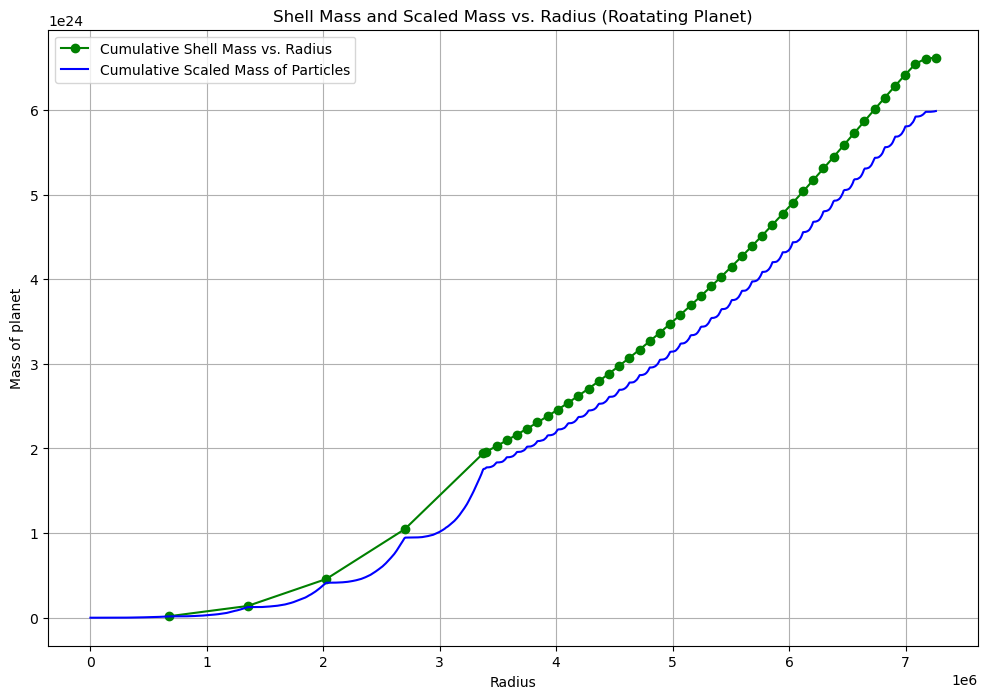

Sum of all scaled particle masses: 5.98796e+24 kg
Time taken: 0.5571527481079102 seconds


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm
import sys
import time

sys.path.append('/home/kh23622/HERCULES_development/Python_scripts')
from HERCULES_structures import *


def read_hercules_output(file_path):
    # Read the binary file containing the planet's parameters and density profile
    with open(file_path, 'rb') as f:
        parameters = HERCULES_parameters()
        parameters.read_binary(f)
        planet = HERCULES_planet()
        planet.read_binary(f)
    return planet

def shell_volume(r1, r2):
    return (4/3) * np.pi * (r1**3 - r2**3)

def calculate_particles_in_shell(shell_mass, num_particles, total_mass):
    num_particles_per_shell = (shell_mass * num_particles) / total_mass
    return int(np.round(num_particles_per_shell))

def generate_particle_coordinates(r1, r2, num_particles):
    phi = np.random.uniform(0, 2 * np.pi, num_particles)
    theta = np.random.uniform(0, np.pi, num_particles)
    
    u = np.random.uniform(0, 1, num_particles)
    r = r2 + (r1 - r2) * u**(1/3)

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return x, y, z

def equal_area_latitude_stretching(x, y, z, N):
    a = 0.2
    
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    
    theta_stretched = np.arccos(np.cos(theta) * np.sqrt(1 - a * np.sin(theta) ** 2))
    
    x_stretched = r * np.sin(theta_stretched) * np.cos(np.arctan2(y, x))
    y_stretched = r * np.sin(theta_stretched) * np.sin(np.arctan2(y, x))
    z_stretched = r * np.cos(theta_stretched)
    
    return x_stretched, y_stretched, z_stretched

def rotate_particles(x, y, z):
    theta = np.random.uniform(0, 2 * np.pi)
    phi = np.random.uniform(0, np.pi)
    
    R = np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi)],
        [np.sin(theta), np.cos(theta)*np.cos(phi), -np.cos(theta)*np.sin(phi)],
        [0, np.sin(phi), np.cos(phi)]
    ])
    
    rotated_coords = np.dot(R, np.vstack([x, y, z]))
    return rotated_coords[0], rotated_coords[1], rotated_coords[2]

def main():
    start_time = time.time()  # Start timing
    file_path = "C:\\Users\\Nischayee\\HERCULES\\Tutorial\\Analysis Script\\output\\testing_Earth_S5.0c_L1.00857_N50_Nm200_k12_f021_p10_l0.92_0.1_2_17"
    planet = read_hercules_output(file_path)
    
    total_mass = planet.Mtot
    print(f"Total Mass of the Planet: {total_mass:.5e} kg")
    
    num_particles = 50000
    
    layers = planet.Nlayer
    particle_positions = []
    particle_masses = []
    particle_densities = []

    all_particles_count = 0
    shell_radii = []
    shell_masses = []
    
    for i in range(layers):
        shell_density = planet.real_rho[i]
        current_radius = planet.layers[i].a
        next_radius = planet.layers[i + 1].a if i < layers - 1 else 0
        
        shell_vol = shell_volume(current_radius, next_radius)
        
        if shell_vol < 0:
            raise ValueError(f"Negative volume calculated at layer {i}. Check radius values.")
        
        shell_mass = shell_density * shell_vol
        shell_radii.append(current_radius)
        shell_masses.append(shell_mass)
        
        num_shell_particles = calculate_particles_in_shell(shell_mass, num_particles, total_mass)
        all_particles_count += num_shell_particles
        
        if num_shell_particles > 0:
            x, y, z = generate_particle_coordinates(current_radius, next_radius, num_shell_particles)
            x, y, z = equal_area_latitude_stretching(x, y, z, num_shell_particles)
            x, y, z = rotate_particles(x, y, z)
            
            # Store positions
            particle_positions.append((x, y, z))
            
            # Store the density
            particle_densities.append(np.full(num_shell_particles, shell_density))
    
    # Scale the mass of each particle
    mass_per_particle = total_mass / all_particles_count

    # Apply the scaled mass to all particles
    for i in range(len(particle_positions)):
        particle_masses.append(np.full(len(particle_positions[i][0]), mass_per_particle))
    
    # Concatenate all properties
    x_all = np.concatenate([p[0] for p in particle_positions])
    y_all = np.concatenate([p[1] for p in particle_positions])
    z_all = np.concatenate([p[2] for p in particle_positions])

    all_masses = np.concatenate(particle_masses)
    all_densities = np.concatenate(particle_densities)

    # Calculate the cumulative mass vs radius
    cumulative_mass = np.zeros_like(shell_radii)
    sorted_radii = np.sort(shell_radii)
    cumulative_mass_sorted = np.zeros_like(sorted_radii)

    for i, r in enumerate(sorted_radii):
        cumulative_mass_sorted[i] = np.sum([shell_mass for radius, shell_mass in zip(shell_radii, shell_masses) if radius <= r])
    
    # Calculate the cumulative scaled mass vs radius
    radius_range = np.linspace(0, np.max(shell_radii), 1000)
    cumulative_scaled_mass = np.zeros_like(radius_range)
    
    for i, r in enumerate(radius_range):
        num_particles_greater_than_r = np.sum(np.sqrt(x_all**2 + y_all**2 + z_all**2) <= r)
        cumulative_scaled_mass[i] = (num_particles_greater_than_r / len(x_all)) * total_mass

    # Plot Mass vs Radius
    plt.figure(figsize=(12, 8))
    
    # Plot the cumulative mass of the planet's layers vs radius
    plt.plot(sorted_radii, cumulative_mass_sorted, 'o-', color='green', label='Cumulative Shell Mass vs. Radius')
    
    # Plot the cumulative scaled mass of particles vs radius
    plt.plot(radius_range, cumulative_scaled_mass, color='blue', label='Cumulative Scaled Mass of Particles')
    
    plt.xlabel('Radius')
    plt.ylabel('Mass of planet')
    plt.title('Shell Mass and Scaled Mass vs. Radius (Roatating Planet)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the sum of all scaled particle masses
    print(f"Sum of all scaled particle masses: {np.sum(all_masses):.5e} kg")

    end_time = time.time()  # End timing
    print(f"Time taken: {end_time - start_time} seconds")

   
if __name__ == "__main__":
    main()
